<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/AI%ED%95%AD%EA%B3%B5%ED%8E%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 대회 소개**
- 항공편 운항 관련 정보를 활용하여 항공편 지연 여부를 예측하는 모델 개발
- 데이터의 경우 레이블이 없는 경우가 많음
  - 준지도학습 방식을 활용할 예정

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# os 관리를 위한 라이브러리
import os
import gc

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
seed_everything(42) # Seed 고정

# **✔ csv to parquet**
- [참고자료](https://butter-shower.tistory.com/245)  
- 메모리에 효율적인 데이터 유형을 사용하여 용량을 줄이고 빠른 작업이 가능함

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path) # 기존 방식대로 파일을 읽어와 dataframe 형태로 저장
    df.to_parquet(f'./{save_name}.parquet') # DataFrame to Parquet
    del df # 기존의 데이터프레임 삭제
    gc.collect() # 가비지 수거(사용되지 않는 메모리 회수)
    print(save_name, 'Done.')

In [ ]:
# csv_to_parquet('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/YB/summer_proj/data/train.csv', 'train')
# csv_to_parquet('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/YB/summer_proj/data/test.csv', 'test')

# **1. 데이터 불러오기**

In [8]:
train=pd.read_csv("/content/drive/MyDrive/ESAA_data/train.csv")
test=pd.read_csv("/content/drive/MyDrive/ESAA_data/test.csv")
sample_submission=pd.read_csv("/content/drive/MyDrive/ESAA_data/sample_submission.csv")

In [9]:
train.head(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN


In [10]:
test.head(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
0,TEST_000000,12,16,1156.0,NaN,0,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402
1,TEST_000001,9,12,1500.0,1715.0,0,0,EWR,11618,New Jersey,ATL,10397,NaN,746.0,Delta Air Lines Inc.,DL,19790.0,N3765
2,TEST_000002,3,6,1600.0,1915.0,0,0,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA


In [11]:
sample_submission.head(3)

,ID,Not_Delayed,Delayed
0,TEST_000000,0,1
1,TEST_000001,0,1
2,TEST_000002,0,1


# **2. 데이터 전처리**

## **📌 Data Description**
**항공편 운항 관련 정보**  
- ID : 샘플 고유 id
- Month: 해당 항공편의 출발 월
- Day_of_Month: Month에 해당하는 월의 날짜
- Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간  
(현지 시각, HH:MM 형식)
- Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간  
(현지 시각, HH:MM 형식)
- Cancelled: 해당 항공편의 취소 여부  
(0: 취소되지 않음, 1: 취소됨)
- Diverted: 해당 항공편의 경유 여부  
(0: 취소되지 않음, 1: 취소됨)
- Origin_Airport: 해당 항공편 출발 공항의 고유 코드(IATA 공항 코드)
- Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID(US DOT ID)
- Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
- Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
- Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
- Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
- Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
- Airline: 해당 항공편을 운항하는 항공사
- Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드  
(IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
- Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
- Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
- Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
  - 예측해야 하는 **타깃**
  - 다수의 데이터에 레이블이 존재하지 않음
  - 준지도학습을 통해 레이블링 가능

In [12]:
### 데이터 형태 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [13]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


- 컬럼명이 전체적으로 길고 복잡하다는 느낌이 있다.
  - 컬럼명을 적절히 변경
- ```Estimated_Departure_Time```, ```Estimated_Arrival_Time```, ```Origin_State```, ```Destination_State```, ```Airline```, ```Carrier_Code(IATA)```, ```Carrier_ID(DOT)```에 결측치 존재
  - 결측치 처리 필요
- 비슷한 정보들을 포함하고 있는 컬럼들이 존재
  - 여러 개를 합치거나 변수를 선택적으로 활용
- 데이터 간 스케일 차이가 존재
  - 스케일링 진행

## **2-1. 각 변수별로 보기**

### **(a) ID**
- ID의 경우 항공편 지연 예측에 대해 제공하는 정보가 없음
  - 그저 데이터 구분을 위한 인덱스 정도
> 해당 변수 삭제

In [14]:
train = train.drop(['ID'], axis = 1)
test = test.drop(['ID'], axis = 1)

### **(b) Month & Day_of_Month**
- **특정 날짜**에 따라 항공편 지연 여부가 다를 것임
  - 월과 일을 합쳐 하나의 날짜로 보기
  - 크리스마스 등의 기념일, 국경일 등
  - ```Holiday``` 파생 변수를 생성하여 국경일인지 아닌지를 표시(0: 공휴일 아님, 1: 공휴일)
  - [미국 공휴일](https://ko.wikipedia.org/wiki/%EB%AF%B8%EA%B5%AD%EC%9D%98_%EA%B3%B5%ED%9C%B4%EC%9D%BC)
- **월**의 경우 항공편 지연과 관련이 있을수도 있음
  - 겨울같이 눈이 많이 오는 경우 항공편이 지연될 가능성이 더 높을 것이다.
  - 계절로 구분

In [15]:
### 날짜 처리

train.loc[:,'Month'] = train['Month'].apply(lambda x: str(x) if x >= 10 else (str(0) + str(x))) # 04
train.loc[:,'Day_of_Month'] = train['Day_of_Month'].apply(lambda x: str(x) if x >= 10 else (str(0) + str(x))) # 09
train['Date'] = train['Month'] + train['Day_of_Month'] # 날짜 변수 추가

test.loc[:,'Month'] = test['Month'].apply(lambda x: str(x) if x >= 10 else (str(0) + str(x)))
test.loc[:,'Day_of_Month'] = test['Day_of_Month'].apply(lambda x: str(x) if x >= 10 else (str(0) + str(x)))
test['Date'] = test['Month'] + test['Day_of_Month']

train = train.drop('Day_of_Month', axis = 1) # 일과 관련된 변수는 제거
test = test.drop('Day_of_Month', axis = 1)

In [16]:
train.head(3)

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Date
0,04,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN,0415
1,08,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN,0815
2,09,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN,0906


In [17]:
test.head(3)

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Date
0,12,1156.0,NaN,0,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402,1216
1,09,1500.0,1715.0,0,0,EWR,11618,New Jersey,ATL,10397,NaN,746.0,Delta Air Lines Inc.,DL,19790.0,N3765,0912
2,03,1600.0,1915.0,0,0,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA,0306


In [18]:
### 공휴일 처리
# 일단 날짜가 지정된 공휴일 위주로 고려
# 주차로 지정된 경우 중간 날짜를 공휴일로 처리
# 잘 쉬지 않는 공휴일은 제외
# 지정일 공휴일 기준 전후 4일 포함
# 지정되지 않은 공휴일 기준 전주 금토일부터 해당주 일요일까지 포함

holiday_li = ['1228','1229','1230','1231','0101','0102','0103','0104','0105','0115',
              '0116','0117', '0118','0119','0120','0121','0122','0123','0124',
              '0521','0522','0523','0524','0525','0526','0527','0528','0529','0530',
              '0630','0701','0702','0703','0704','0705','0706','0707','0708',
              '0901','0902','0903','0904','0905','0906','0907','0908','0909','0910',
              '1117','1118','1119','1120','1121','1122','1123','1124','1125','1126','1127','1128',
              '1221','1222','1223','1224','1225','1226','1227','1228','1229']

train.loc[:,'Holiday'] = train['Date'].apply(lambda x: 1 if x in holiday_li else 0)
test.loc[:,'Holiday'] = test['Date'].apply(lambda x: 1 if x in holiday_li else 0)

train = train.drop('Date', axis = 1) # 날짜와 관련된 변수는 제거
test = test.drop('Date', axis = 1)

### **(c) Cancelled, Diverted**
- train.describe()를 통해 확인한 결과 모두 0임
> 제공해 주는 정보가 없는 변수들이기에 제거

In [19]:
train = train.drop(['Cancelled', 'Diverted'], axis = 1)
test = test.drop(['Cancelled', 'Diverted'], axis = 1)

### **(d) Origin_Airport & Origin_Airport_ID**
- 하나의 공항을 두고 표기하는 방법이 다른 것 같음
  - 그냥 처리하는 부서(?)에 따른 차이인 것 같음
> ID를 남기기로 결정  
(이따 ```Carrier_Code```, ```Carrier_ID```에서 id를 남길 예정이므로 통일감을 주기 위해서)

In [20]:
train = train.drop(['Origin_Airport'], axis = 1)
test = test.drop(['Origin_Airport'], axis = 1)

### **(e) Destination_Airport & Destination_Airport_ID**
- 출발지와 동일하게 도착지도 처리

In [21]:
train = train.drop(['Destination_Airport'], axis = 1)
test = test.drop(['Destination_Airport'], axis = 1)

### **(f) Origin_State & Destination_State**
- 미국의 주는 너무 광범위함
  - 공항이라는 더 작은 범위가 있는데 굳이 주를..
  - 우리나라로 치면 김해국제공항 냅두고 경상북도 보는 느낌..
> 해당 변수들을 삭제

In [22]:
train = train.drop(['Origin_State', 'Destination_State'], axis = 1)
test = test.drop(['Origin_State', 'Destination_State'], axis = 1)

### **(g) Carrier_Code(IATA) & Carrier_ID(DOT)**
- 하나의 항공사를 두고 표기하는 방법이 다른 것 같음
- ```Carrier_Code```의 경우 IATA 공항 코드를 활용하기에, 다른 항공사라도 같은 코드를 보유할 수도 있기에, 고유성이 떨어짐
> Carrier_ID(DOT)를 활용하자.

In [23]:
train = train.drop(['Carrier_Code(IATA)'], axis = 1)
test = test.drop(['Carrier_Code(IATA)'], axis = 1)

## **2-2. 결측치 처리**

In [24]:
### 데이터 구조 재확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Month                     1000000 non-null  object 
 1   Estimated_Departure_Time  890981 non-null   float64
 2   Estimated_Arrival_Time    890960 non-null   float64
 3   Origin_Airport_ID         1000000 non-null  int64  
 4   Destination_Airport_ID    1000000 non-null  int64  
 5   Distance                  1000000 non-null  float64
 6   Airline                   891080 non-null   object 
 7   Carrier_ID(DOT)           891003 non-null   float64
 8   Tail_Number               1000000 non-null  object 
 9   Delay                     255001 non-null   object 
 10  Holiday                   1000000 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 83.9+ MB


In [25]:
train.describe()

,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT),Holiday
count,890981.000000,890960.000000,1000000.000000,1000000.000000,1000000.000000,891003.000000,1000000.000000
mean,1341.153019,1493.295934,12696.278484,12701.813986,784.078499,19997.388093,0.187332
std,489.814011,520.803494,1514.938441,1515.213044,590.790469,404.268639,0.390178
min,1.000000,1.000000,10135.000000,10135.000000,16.000000,19393.000000,0.000000
25%,925.000000,1105.000000,11292.000000,11292.000000,350.000000,19790.000000,0.000000
50%,1332.000000,1524.000000,12889.000000,12889.000000,623.000000,19977.000000,0.000000
75%,1742.000000,1924.000000,14057.000000,14057.000000,1020.000000,20378.000000,0.000000
max,2359.000000,2400.000000,16869.000000,16869.000000,5095.000000,21171.000000,1.000000


In [26]:
### column 함수를 기준으로 결측값을 계산하는 함수

def missing_values_table(df):
        # 데이터 내에서 결측치의 총 개수
        mis_val = df.isnull().sum()

        # 전체 데이터에 대한 결측치의 비율
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # 결과 테이블 만들기
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1) # 컬럼 방향으로 결합

        # 컬럼명 재정의
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # 결측치의 비율을 기준으로 내림차순 정렬
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                '% of Total Values', ascending = False).round(1) # 소수 첫째자리에서 반올림

        # 요약 정보 출력
        print ("선택된 데이터프레임은 " + str(df.shape[1]) + "개의 변수를 가지고 있습니다.\n"
            "이때 결측치(missing value)를 가지는 변수의 개수는 " + str(mis_val_table_ren_columns.shape[0]) +
              "개 입니다.\n")
        return mis_val_table_ren_columns

In [27]:
# 결측치에 대한 요약 정보 확인

missing_values = missing_values_table(train)
missing_values

선택된 데이터프레임은 11개의 변수를 가지고 있습니다.
이때 결측치(missing value)를 가지는 변수의 개수는 5개 입니다.



,Missing Values,% of Total Values
Delay,744999,74.5
Estimated_Arrival_Time,109040,10.9
Estimated_Departure_Time,109019,10.9
Carrier_ID(DOT),108997,10.9
Airline,108920,10.9


### **(a) Estimated_Departure_Time(EDT) & Estimated_Arrival_Time(EAT)**
- 비행시간 = Estimated_Arrival_Time - Estimated_Departure_Time으로 계산할 수 있음
  - ```Flying_Time``` 변수 추가
  - 시간 계산을 편하게 하기 위해 HH:MM 형식을 분 형식으로 변경(하루 = 24시간 * 60분 = 1440분)
  - (도착시간 - 출발시간) < 0일 수 있음
    - 보정방법: 1440 - 출발시간 + 도착시간 = 1440 + (도착시간 - 출발시간)
    - 15시 출발해서 9시 도착: 1440 - 15 * 60 + 9 * 60 = 1080(분) 소요
---
- 비행시간은 출발 공항과 도착 공항 사이의 거리에 비례할 것임
  - 출발시간과 도착 시간 중 하나라도 알고 있다면 공항 간의 거리를 통해 유추 가능


In [28]:
# train 데이터의 경우 출발시간과 도착시간이 모두 결측치인 데이터(행)는 제거

train = train.dropna(subset = ['Estimated_Departure_Time', 'Estimated_Departure_Time'],
                     how = 'all', axis = 0)

In [29]:
# test 데이터의 경우 미리 출발시간과 도착시간이 모두 결측치인 데이터(행)의 경우 최빈값으로 결측치 채우기

missing = test[test['Estimated_Departure_Time'].isnull() & test['Estimated_Arrival_Time'].isnull()]

# 결측치를 최빈값으로 대체하기
departure_mode = test['Estimated_Departure_Time'].mode().values[0]
arrival_mode = test['Estimated_Arrival_Time'].mode().values[0]

test.loc[missing.index, 'Estimated_Departure_Time'] = departure_mode
test.loc[missing.index, 'Estimated_Arrival_Time'] = arrival_mode

In [30]:
### 비행시간(Flying_Time) 추가

# 시간 -> 분(수상자 코드 참고)
def time_to_min(x):
  x = int(x)
  x = str(x)

  if len(x) > 2: # 1시간 이상(시간의 개념이 존재)
    hour, min = int(x[:-2]), int(x[-2:])
  else:
    hour, min = 0, int(x[-2:])

  return hour * 60 + min

In [31]:
train.loc[:,'Estimated_Departure_Time'] = train['Estimated_Departure_Time'].apply(lambda x:time_to_min(x) if not np.isnan(x) else np.nan)
train.loc[:,'Estimated_Arrival_Time'] = train['Estimated_Arrival_Time'].apply(lambda x:time_to_min(x) if not np.isnan(x) else np.nan)

train['Flying_Time'] = train['Estimated_Arrival_Time'] - train['Estimated_Departure_Time']
train.loc[:, 'Flying_Time'] = train['Flying_Time'].apply(lambda x: x + 1440 if x < 0 else x)

<ipython-input-31-59235367f48d>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:,'Estimated_Departure_Time'] = train['Estimated_Departure_Time'].apply(lambda x:time_to_min(x) if not np.isnan(x) else np.nan)


In [32]:
test.loc[:,'Estimated_Departure_Time'] = test['Estimated_Departure_Time'].apply(lambda x:time_to_min(x) if not np.isnan(x) else np.nan)
test.loc[:,'Estimated_Arrival_Time'] = test['Estimated_Arrival_Time'].apply(lambda x:time_to_min(x) if not np.isnan(x) else np.nan)

test['Flying_Time'] = test['Estimated_Arrival_Time'] - test['Estimated_Departure_Time']
test.loc[:, 'Flying_Time'] = test['Flying_Time'].apply(lambda x: x + 1440 if x < 0 else x)

In [33]:
### 거리(Distance), 비행시간(Flying_Time) 대응시키기
# 동일한 거리에 따라, 비행시간의 최빈값을 구해 대응시킴

# 거리별 flying_time의 최빈값을 구하는 함수
def get_mode(x):
  modes = x.mode().values
  mode = np.mean(modes) # 최빈값이 여러개인 경우 해당 값들의 평균을 택함
  if pd.isna(mode):
    return np.NaN
  else:
    return int(mode)

In [34]:
# 거리별로 그룹화하고 flying_time의 최빈값을 구하기
result_dict = train.groupby('Distance')['Flying_Time'].apply(get_mode).to_dict()

# Distance에 대응되는 값으로 Flying_Time의 결측치 채우기
train['Flying_Time'] = train.apply(lambda row: result_dict[row['Distance']]
                                   if pd.isnull(row['Flying_Time']) else row['Flying_Time'], axis=1)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
result_dict2 = test.groupby('Distance')['Flying_Time'].apply(get_mode).to_dict()

# Distance에 대응되는 값으로 Flying_Time의 결측치 채우기
test['Flying_Time'] = test.apply(lambda row: result_dict2[row['Distance']]
                                   if pd.isnull(row['Flying_Time']) else row['Flying_Time'], axis=1)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
### 결측치 채우기

train['Estimated_Arrival_Time'] = train['Estimated_Arrival_Time'].fillna(train['Flying_Time'] + train['Estimated_Departure_Time'])
train['Estimated_Departure_Time'] = train['Estimated_Departure_Time'].fillna(train['Estimated_Arrival_Time'] - train['Flying_Time'])

train.loc[:, 'Estimated_Arrival_Time'] = train['Estimated_Arrival_Time'].apply(lambda x: x - 1440 if x > 1440 else x)
train.loc[:, 'Estimated_Departure_Time'] = train['Estimated_Departure_Time'].apply(lambda x: x - 1440 if x > 1440 else x)

In [37]:
test['Estimated_Arrival_Time'] = test['Estimated_Arrival_Time'].fillna(test['Flying_Time'] + test['Estimated_Departure_Time'])
test['Estimated_Departure_Time'] = test['Estimated_Departure_Time'].fillna(test['Estimated_Arrival_Time'] - test['Flying_Time'])

test.loc[:, 'Estimated_Arrival_Time'] = test['Estimated_Arrival_Time'].apply(lambda x: x - 1440 if x > 1440 else x)
test.loc[:, 'Estimated_Departure_Time'] = test['Estimated_Departure_Time'].apply(lambda x: x - 1440 if x > 1440 else x)

In [38]:
# 비행시간 변수는 더이상 필요 없으므로 제거

train = train.drop('Flying_Time', axis = 1)
test = test.drop('Flying_Time', axis = 1)

In [39]:
train.head(3)

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Airline,Carrier_ID(DOT),Tail_Number,Delay,Holiday
1,08,460,624.0,13930,14869,1250.0,SkyWest Airlines Inc.,20304.0,N125SY,NaN,0
2,09,970,1085.0,11057,12953,544.0,American Airlines Inc.,19805.0,N103US,NaN,1
3,07,545,1055.0,12892,11618,2454.0,United Air Lines Inc.,NaN,N595UA,NaN,0


In [40]:
test.head(3)

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Airline,Carrier_ID(DOT),Tail_Number,Holiday
0,12,716.0,779.0,12266,14683,191.0,United Air Lines Inc.,NaN,N79402,0
1,09,900.0,1035.0,11618,10397,746.0,Delta Air Lines Inc.,19790.0,N3765,0
2,03,960.0,1155.0,13930,12953,733.0,United Air Lines Inc.,19977.0,N413UA,0


### **(b) Airline & Carrier_ID(DOT)**
- 데이터 설명을 통해, ```Airline```과 ```Carrier_ID(DOT)```는 일대일 대응되는 것을 확인할 수 있음
> ```Airline```을 활용하여 ```Carrier_ID``` 채우기

In [41]:
### 결측치 처리를 할 수 있는 데이터 개수 파악하기
# Airline은 있고 Carrier_ID(DOT)는 없는 경우

print(len(train.loc[train['Carrier_ID(DOT)'].isnull() & train['Airline'].notnull(), :]))
print(len(test.loc[test['Carrier_ID(DOT)'].isnull() & test['Airline'].notnull(), :]))

86564
97463


In [42]:
### Airline과 Carrier_ID 연결하기
# key: Airline. Value: Carrier_ID

result_dict3 = {}

# 데이터를 행별로 조회하면서 연결
for _, row in train[train['Carrier_ID(DOT)'].notnull() & train['Airline'].notnull()].iterrows():
  result_dict3[row['Airline']] = row['Carrier_ID(DOT)']

train['Carrier_ID(DOT)'] = train.apply(lambda row: result_dict3.get(row['Airline'], None)
                                        if pd.isnull(row['Carrier_ID(DOT)']) else row['Carrier_ID(DOT)'], axis=1)

In [43]:
result_dict4 = {}

# 데이터를 행별로 조회하면서 연결
for _, row in test[test['Carrier_ID(DOT)'].notnull() & test['Airline'].notnull()].iterrows():
  result_dict4[row['Airline']] = row['Carrier_ID(DOT)']

test['Carrier_ID(DOT)'] = test.apply(lambda row: result_dict4.get(row['Airline'], None)
                                        if pd.isnull(row['Carrier_ID(DOT)']) else row['Carrier_ID(DOT)'], axis=1)

In [44]:
# train의 경우 여전히 Carrier_ID(DOT)에 결측치가 있는 데이터는 삭제

train = train.dropna(subset = ['Carrier_ID(DOT)'],
                     how = 'any', axis = 0)

In [45]:
# test의 경우 여전히 Carrier_ID(DOT)에 결측치가 있는 데이터의 경우 최빈값으로 대체

nan_idx = test[test['Carrier_ID(DOT)'].isnull()].index
carrier_mode = test['Carrier_ID(DOT)'].mode().values[0]
test.loc[nan_idx, 'Carrier_ID(DOT)'] = carrier_mode

In [46]:
# Airline 변수는 더 이상 필요 없으므로 삭제

train = train.drop('Airline', axis = 1)
test = test.drop('Airline', axis = 1)

In [47]:
train.head()

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT),Tail_Number,Delay,Holiday
1,08,460,624.0,13930,14869,1250.0,20304.0,N125SY,NaN,0
2,09,970,1085.0,11057,12953,544.0,19805.0,N103US,NaN,1
3,07,545,1055.0,12892,11618,2454.0,19977.0,N595UA,NaN,0
4,01,540,619.0,14771,10157,250.0,20304.0,N161SY,NaN,0
5,04,945,1011.0,11618,11278,199.0,20452.0,N657RW,Not_Delayed,0


In [48]:
test.head()

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT),Tail_Number,Holiday
0,12,716.0,779.0,12266,14683,191.0,19977.0,N79402,0
1,09,900.0,1035.0,11618,10397,746.0,19790.0,N3765,0
2,03,960.0,1155.0,13930,12953,733.0,19977.0,N413UA,0
3,05,1160.0,1245.0,13796,12892,337.0,19393.0,N905WN,0
4,07,1155.0,1312.0,11697,12892,2343.0,20409.0,N945JT,1


### **결측치 확인**

In [49]:
# 결측치에 대한 요약 정보 재확인

missing_values = missing_values_table(train)
missing_values

선택된 데이터프레임은 10개의 변수를 가지고 있습니다.
이때 결측치(missing value)를 가지는 변수의 개수는 2개 입니다.



,Missing Values,% of Total Values
Delay,655893,74.5
Estimated_Arrival_Time,1,0.0


In [50]:
# test

missing_values2 = missing_values_table(test)
missing_values2

선택된 데이터프레임은 9개의 변수를 가지고 있습니다.
이때 결측치(missing value)를 가지는 변수의 개수는 1개 입니다.



,Missing Values,% of Total Values
Estimated_Arrival_Time,2,0.0


In [51]:
# 여전히 결측치가 존재함(코드 조금 잘못 짠 듯)
# 해당 결측치는 소수이므로 그냥 제거해준다.

train = train.dropna(subset = ['Estimated_Arrival_Time'],
                     how = 'any', axis = 0)
test = test.dropna(subset = ['Estimated_Arrival_Time'],
                     how = 'any', axis = 0)

## **2-3. 변수 형태 확인**

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880390 entries, 1 to 999999
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     880390 non-null  object 
 1   Estimated_Departure_Time  880390 non-null  int64  
 2   Estimated_Arrival_Time    880390 non-null  float64
 3   Origin_Airport_ID         880390 non-null  int64  
 4   Destination_Airport_ID    880390 non-null  int64  
 5   Distance                  880390 non-null  float64
 6   Carrier_ID(DOT)           880390 non-null  float64
 7   Tail_Number               880390 non-null  object 
 8   Delay                     224498 non-null  object 
 9   Holiday                   880390 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 73.9+ MB


In [53]:
### 데이터형 변경
# 데이터형을 적절한 형태로 변경

train = train.astype({'Month':'int64', 'Estimated_Arrival_Time':'int64', 'Carrier_ID(DOT)':'int64'})
test = test.astype({'Estimated_Departure_Time':'int64', 'Estimated_Arrival_Time':'int64', 'Carrier_ID(DOT)':'int64','Month':'int64'})

In [54]:
train.describe()

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT),Holiday
count,880390.000000,880390.000000,880390.000000,880390.000000,880390.000000,880390.000000,880390.000000,880390.000000
mean,6.945966,815.599928,905.878090,12696.513123,12702.091538,784.093085,19997.696396,0.187453
std,3.462980,294.684627,314.642283,1514.450326,1515.082800,590.567670,404.151468,0.390275
min,1.000000,1.000000,1.000000,10135.000000,10135.000000,16.000000,19393.000000,0.000000
25%,4.000000,565.000000,665.000000,11292.000000,11292.000000,350.000000,19790.000000,0.000000
50%,7.000000,813.000000,922.000000,12889.000000,12889.000000,623.000000,19977.000000,0.000000
75%,10.000000,1062.000000,1163.000000,14057.000000,14057.000000,1020.000000,20378.000000,0.000000
max,12.000000,1439.000000,1440.000000,16869.000000,16869.000000,5095.000000,21171.000000,1.000000


- 일부 데이터에 대해 이상치가 존재함을 확인할 수 있음

## **2-4. 범주형 변수 Encoding**
- 대부분의 범주형 변수들이 수치형으로 잘 처리되어 있다.
- 추가적으로 변환이 필요한 변수들에 대해 LabelEncoding 진행

In [55]:
from sklearn.preprocessing import LabelEncoder

cat = ['Tail_Number']

le = LabelEncoder() # 객체 생성
for i in cat:
  le = le.fit(train[i])
  train[i]=le.transform(train[i])

  for label in np.unique(test[i]):
    if label not in le.classes_:
      le.classes_ = np.append(le.classes_, label)
  test[i] = le.transform(test[i])

In [56]:
### Delay(target) 변수 인코딩
# 라벨이 없는 경우 LabelEncoder가 정상적으로 작동하지 않음
# 따라서, 일단 라벨이 있는 데이터에 대해서만 인코딩 진행

le2 = LabelEncoder() # 객체 생성

le2 = le2.fit(train.loc[train['Delay'].notnull(),'Delay'])
train.loc[train['Delay'].notnull(),'Delay'] = le2.transform(train.loc[train['Delay'].notnull(),'Delay'])

In [57]:
train.head(3)

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT),Tail_Number,Delay,Holiday
1,8,460,624,13930,14869,1250.0,20304,310,NaN,0
2,9,970,1085,11057,12953,544.0,19805,140,NaN,1
3,7,545,1055,12892,11618,2454.0,19977,3016,NaN,0


In [58]:
test.head(3)

,Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT),Tail_Number,Holiday
0,12,716,779,12266,14683,191.0,19977,4382,0
1,9,900,1035,11618,10397,746.0,19790,1934,0
2,3,960,1155,13930,12953,733.0,19977,2144,0


### **2-5. 이상치 처리**
- IQR 활용

In [59]:
train.shape

(880390, 10)

In [60]:
# 이상치 제거 함수
def remove_outliers_iqr(df, threshold = 1.5):
  for column in df.select_dtypes(include=np.number).columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    cutoff = iqr * threshold # 주로 IQR * 1.5를 임계값으로 설정

    lower_bound = q1 - cutoff
    upper_bound = q3 + cutoff

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

  return df

In [61]:
train = remove_outliers_iqr(train)
train.shape

(675015, 10)

## **모델링**

RandomForest-일반코드(참고용)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [63]:
#X = train.drop(columns='Delay')
#y = train['Delay']
#X_train, X_test, y_train, y_test = train_test_split(
#    X , y ,
#    test_size=0.2,
#    random_state=42
#)

In [64]:
#X_features = train.drop(columns = 'Delay',axis=1)
#y_labels = train['Delay']
#X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)
#train_cnt = y_train.count()
#test_cnt = y_test.count()
#print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

#print('학습 세트 레이블 값 분포 비율')
#print(y_train.value_counts()/train_cnt)
#print('\n 테스트 세트 레이블 값 분포 비율')
#print(y_test.value_counts()/test_cnt)

In [65]:
#rf_clf = RandomForestClassifier(random_state=0)
#rf_clf.fit(X_train,y_train)
#pred = rf_clf.predict(X_test)

In [66]:
#accuracy = accuracy_score(y_test, pred)
#print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

**준지도학습-RandomForest**

In [67]:
# 학습 데이터 분리
train_labeled=train.loc[train['Delay'].notnull(),:]
train_unlabeled=train.loc[train['Delay'].isnull(),:]

X_labeled=train_labeled.drop(['Delay'],axis=1)
y_labeled=train_labeled['Delay']
X_unlabeled=train_unlabeled.drop(['Delay'],axis=1)

In [75]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# 레이블이 있는 샘플 데이터 생성
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, random_state=42)

# 레이블이 있는 데이터와 레이블이 없는 데이터로 분할
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.7, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_labeled = scaler.fit_transform(X_labeled)
X_unlabeled = scaler.transform(X_unlabeled)

# 초기 모델 학습
initial_model = RandomForestClassifier(n_estimators=100, random_state=42)
initial_model.fit(X_labeled, y_labeled)
#--> 오류 생성, NaN을 포함하는 데이터... 어떻게 분류해야 fit적용이 될지

# 모델을 학습시키기 위해 라벨이 있는 데이터와 라벨이 없는 데이터를 결합
X_train_combined = np.concatenate((X_labeled, X_unlabeled))
y_train_combined = np.concatenate((y_labeled, [-1] * len(X_unlabeled)))  # 라벨이 없는 데이터는 -1로 표시

# 모델을 학습시킴
self_training_model = RandomForestClassifier(n_estimators=100, random_state=42)
self_training_model.fit(X_train_combined, y_train_combined)

# 이후 라벨이 없는 데이터를 예측하여 사용할 수 있음
predictions = self_training_model.predict(X_unlabeled)

# SelfTrainingClassifier 설정
self_training_model = SelfTrainingClassifier(initial_model, criterion='k_best', k_best=10)

self_training_model.fit(X_labeled, y_labeled)
self_training_model.predict = self_training_model.predict(X_unlabeled)

#Pred
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_labeled,y_labeled)
y_unlabeled_pred = rf_clf.predict(X_unlabeled)

In [76]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


# 준지도학습 모델 생성 (probability 매개변수를 True로 설정)
self_training_model = SelfTrainingClassifier(SVC(probability=True), criterion='k_best', k_best=100)

# 라벨이 있는 데이터와 라벨이 없는 데이터를 결합하여 모델을 학습시킴
X_train_combined = np.concatenate((X_labeled, X_unlabeled))
y_train_combined = np.concatenate((y_labeled, [-1] * len(X_unlabeled)))  # 라벨이 없는 데이터는 -1로 표시
self_training_model.fit(X_train_combined, y_train_combined)

# 라벨이 없는 데이터에 대한 예측 확률을 확인할 수 있음
probabilities = self_training_model.predict_proba(X_unlabeled)

In [77]:
# 반복 횟수 설정
num_iterations = 5

for iteration in range(num_iterations):
    # 모델을 학습시킴
    self_training_model.fit(X_train_combined, y_train_combined)

    # 라벨이 없는 데이터에 대한 예측 확률을 확인
    probabilities = self_training_model.predict_proba(X_unlabeled)

    # 예측된 라벨 중 가장 높은 확률을 가진 데이터를 라벨이 있는 데이터로 추가
    confident_predictions = np.argmax(probabilities, axis=1)
    confident_samples = np.max(probabilities, axis=1) > 0.8  # 확신도가 0.8 이상인 샘플 선택 (임계값 조정 가능)
    X_labeled = np.concatenate((X_labeled, X_unlabeled[confident_samples]))
    y_labeled = np.concatenate((y_labeled, confident_predictions[confident_samples]))

    # 확신이 없는 데이터를 다음 반복에 사용하기 위해 유지
    X_unlabeled = X_unlabeled[~confident_samples]

    # 라벨이 있는 데이터와 라벨이 없는 데이터를 다시 결합하여 학습 데이터로 갱신
    X_train_combined = np.concatenate((X_labeled, X_unlabeled))
    y_train_combined = np.concatenate((y_labeled, [-1] * len(X_unlabeled)))  # 라벨이 없는 데이터는 -1로 표시

# Self-Training 알고리즘이 끝나면 최종 모델이 완성됩니다.
final_model = self_training_model

Accuracy: 0.9806517311608961
Precision: 0.9782608695652174
Recall: 0.9840954274353877
F1 Score: 0.981169474727453
ROC AUC Score: 0.9805654590204078


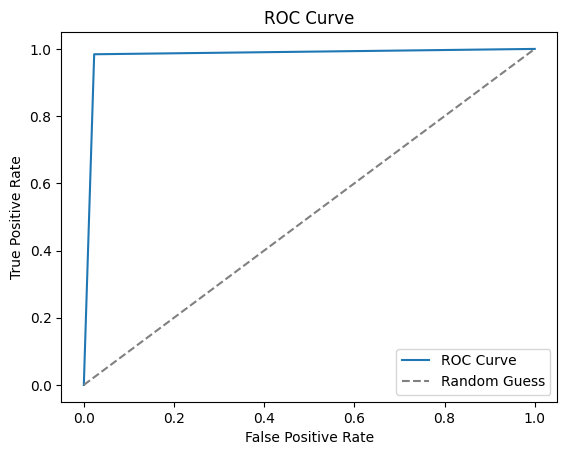

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 라벨이 있는 데이터를 사용하여 랜덤 포레스트 모델 훈련> 라벨이 없는 데이터를 사용하여 Self-Training 모델 훈련
# >라벨이 없는 데이터에 대한 예측 확률을 확인> 확신도가 높은 데이터를 라벨이 있는 데이터로 추가

# 최종 모델의 예측을 수행
final_predictions = self_training_model.predict(X_labeled)

# 모델 성능 평가지표 계산
accuracy = accuracy_score(y_labeled, final_predictions)
precision = precision_score(y_labeled, final_predictions)
recall = recall_score(y_labeled, final_predictions)
f1 = f1_score(y_labeled, final_predictions)
roc_auc = roc_auc_score(y_labeled, final_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(y_labeled, final_predictions)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
